In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Dataset paths
dataset_path = r'D:\university\FER\fer_ckplus_kdef'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')


# Define transformations for train and validation sets
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

# Dataloader setup
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 23650, Validation size: 2631, Test size: 6573


In [4]:
import timm  # For pretrained models

class CNNTransFERNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNTransFERNet, self).__init__()
        
        # Pretrained CNN Backbone (EfficientNet)
        self.cnn = timm.create_model('efficientnet_b0', pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove final classification layer
        
        # Transformer Encoder Layer
        self.transformer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        
        # Fully connected layers
        self.fc1 = nn.Linear(1280, 512)  # Adjust according to the CNN output
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc1(x)
        x = self.transformer(x.unsqueeze(0))
        x = self.fc2(x.squeeze(0))
        return x

# Instantiate model
num_classes = len(train_dataset.classes)
model = CNNTransFERNet(num_classes=num_classes).to(device)
print(model)


c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CNNTransFERNet(
  (cnn): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Con

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        val_epoch_loss, val_epoch_acc = evaluate_model(model, val_loader, criterion)

        train_loss.append(epoch_loss)
        val_loss.append(val_epoch_loss)
        train_acc.append(epoch_acc)
        val_acc.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        scheduler.step()

    return train_loss, val_loss, train_acc, val_acc


In [7]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [8]:
num_epochs = 50
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1/50 -> Train Loss: 1.3557, Train Acc: 0.5129, Val Loss: 1.2069, Val Acc: 0.5591
Epoch 2/50 -> Train Loss: 1.0804, Train Acc: 0.6157, Val Loss: 1.1179, Val Acc: 0.6066
Epoch 3/50 -> Train Loss: 0.9889, Train Acc: 0.6499, Val Loss: 1.1160, Val Acc: 0.5990
Epoch 4/50 -> Train Loss: 1.1148, Train Acc: 0.5971, Val Loss: 1.0617, Val Acc: 0.6287
Epoch 5/50 -> Train Loss: 0.8902, Train Acc: 0.6858, Val Loss: 0.9869, Val Acc: 0.6587
Epoch 6/50 -> Train Loss: 0.6701, Train Acc: 0.7648, Val Loss: 0.9320, Val Acc: 0.6842
Epoch 7/50 -> Train Loss: 0.5962, Train Acc: 0.7929, Val Loss: 0.9301, Val Acc: 0.6921
Epoch 8/50 -> Train Loss: 0.5331, Train Acc: 0.8190, Val Loss: 1.0042, Val Acc: 0.6891
Epoch 9/50 -> Train Loss: 0.4623, Train Acc: 0.8456, Val Loss: 1.0569, Val Acc: 0.6826
Epoch 10/50 -> Train Loss: 0.3959, Train Acc: 0.8711, Val Loss: 1.1637, Val Acc: 0.6800
Epoch 11/50 -> Train Loss: 0.3007, Train Acc: 0.9060, Val Loss: 1.2263, Val Acc: 0.6838
Epoch 12/50 -> Train Loss: 0.2849, Train 

KeyboardInterrupt: 

In [9]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_loss, val_loss, train_acc, val_acc)


NameError: name 'train_loss' is not defined

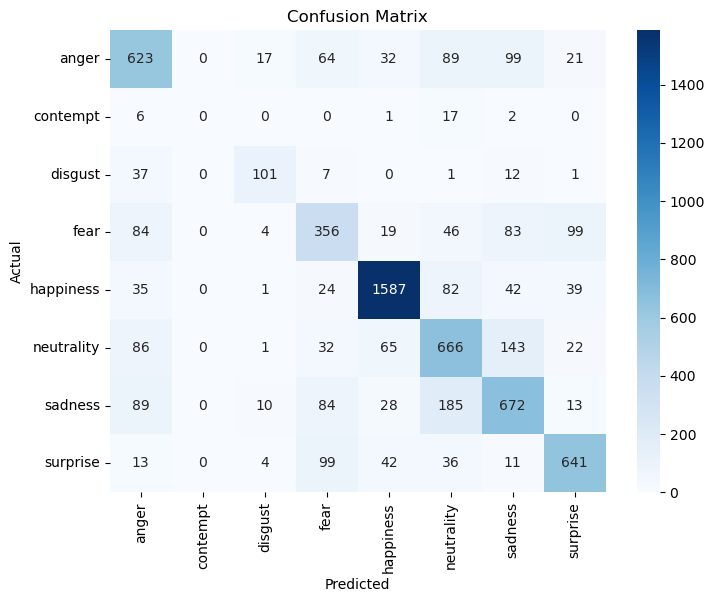

Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.66      0.65       945
    contempt       0.00      0.00      0.00        26
     disgust       0.73      0.64      0.68       159
        fear       0.53      0.52      0.52       691
   happiness       0.89      0.88      0.89      1810
  neutrality       0.59      0.66      0.62      1015
     sadness       0.63      0.62      0.63      1081
    surprise       0.77      0.76      0.76       846

    accuracy                           0.71      6573
   macro avg       0.60      0.59      0.59      6573
weighted avg       0.71      0.71      0.71      6573



c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
def test_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = train_dataset.classes

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_labels))

test_model(model, test_loader)


In [ ]:
torch.save(model.state_dict(), 'cnn_transFERNet.pth')
print("Model saved successfully.")


In [ ]:
import torch

# Define model save path
model_save_path = "CNNTransFERNet.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved as {model_save_path}")


In [ ]:
import zipfile

# Define the zip file name
zip_filename = "CNNTransFERNet_model.zip"

# Create a ZIP file and add the model to it
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_save_path, arcname="CNNTransFERNet.pth")

print(f"Model successfully compressed and saved as {zip_filename}")
